In [1]:
!pip install torch torchvision torchaudio





  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 57.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


In [2]:
# Necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
# Load dataset
df = pd.read_csv("New-Featured-Dataset.csv")
df = df.dropna()  # Drop all rows with at least one NaN value

# Encoding categorical target (strength) [0, 1 and 2 = [1, 0, 0], [0, 1, 0] and [0, 0, 1]]
# label_encoder = LabelEncoder()
# df['Strength'] = label_encoder.fit_transform(df['Strength'])

# Features and target
# X = df.drop(['Strength', 'Password'], axis=1).values
X = df.drop(['Password', 'Strength'], axis=1).values
y = df['Strength'].values

# Feature scaling
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

df

,Password,Length,Count(Alphabets),Count(Numerics),Count(SpecialChars),Count(Uppercase),Count(Lowercase),RepeatedChars,CaseRatio,Strength
0,7hqwv,5.0,4,1,0,0,4,0,0.000000,0
1,cjml,4.0,4,0,0,0,4,0,0.000000,0
2,asuy,4.0,4,0,0,0,4,0,0.000000,0
3,kcyth,5.0,5,0,0,0,5,0,0.000000,0
4,whcq,4.0,4,0,0,0,4,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
5000091,"U,c0Da#<EaW.2(Bd|pGScmj/bJ",26.0,17,2,7,8,9,0,1.125000,4
5000092,0Y</Y{zz^O2*fAWh9G8hE+yEeF^_,28.0,16,4,8,9,7,0,0.777778,4
5000093,"N,tYi',X0pMmnx6_=PLMG",21.0,14,2,5,8,6,0,0.750000,4
5000094,"aBtn>DR_xk4AaEus$R8J!jZ^JKq""KCqt",32.0,24,2,6,12,12,0,1.000000,4


In [4]:
# Split data into train + val (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train + val into train (70%) and val (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print(f'Training:    {X_train.shape}')
print(f'Validation:  {X_val.shape}')
print(f'Testing:     {X_test.shape}')

Training:    (3500065, 8)
Validation:  (500010, 8)
Testing:     (1000019, 8)


In [5]:
# Convert data to torch tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device selected: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

Device selected: cpu


In [6]:
print(torch.isnan(X_train_tensor).any())  # Check for NaNs - should be false
print(torch.isinf(X_train_tensor).any())  # Check for Infs - should be false
X_train_tensor = torch.nan_to_num(X_train_tensor, nan=0.0)

print(torch.isnan(y_train_tensor).any())  # Check for NaNs
print(y_train_tensor.min(), y_train_tensor.max())  # Range of labels
print(y_train_tensor.dtype)  # Ensure dtype is torch.int64 (LongTensor)


tensor(False)
tensor(False)
tensor(False)
tensor(0) tensor(4)
torch.int64


In [7]:
class PasswordNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PasswordNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 128)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.1)        
        self.hidden2 = nn.Linear(128, 64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.1)
        self.hidden3 = nn.Linear(64, 32)
        self.batchnorm3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.1)
        self.output = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.batchnorm1(self.hidden1(x)))  # BatchNorm + ReLU
        x = self.dropout1(x)
        x = torch.relu(self.batchnorm2(self.hidden2(x)))  # BatchNorm + ReLU
        x = self.dropout2(x)
        x = torch.relu(self.batchnorm3(self.hidden3(x)))  # BatchNorm + ReLU
        x = self.dropout3(x)
        x = self.output(x)
        return torch.softmax(x, dim=1)

In [8]:
# Initialize the model, loss function, and optimizer
model = PasswordNN(input_dim=X_train.shape[1], output_dim=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.0001)

In [9]:
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDataset for training, validation, and test data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batching, shuffling, and setting batch size
batch_size = 512  # You can adjust this based on your available memory and preference

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
# Store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    
    batch_train_loss = 0.0
    batch_train_accuracy = 0.0
    num_batches = 0
    
    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate batch accuracy
        _, predicted_train = torch.max(outputs, 1)
        batch_accuracy = (predicted_train == y_batch).sum().item() / y_batch.size(0)
        batch_train_accuracy += batch_accuracy
        batch_train_loss += loss.item()
        
        num_batches += 1
        
        # Print batch data after every 10 batches
        if (i + 1) % 2000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], '
                  f'Batch Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy*100:.2f}%')

    # Calculate average batch loss and accuracy for the epoch
    batch_train_loss /= num_batches
    batch_train_accuracy /= num_batches
    
    # Validation pass
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_accuracy = 0.0
        val_batches = 0
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            val_outputs = model(X_batch)
            val_loss_batch = criterion(val_outputs, y_batch)
            
            # Calculate batch accuracy
            _, predicted_val = torch.max(val_outputs, 1)
            val_accuracy += (predicted_val == y_batch).sum().item() / y_batch.size(0)
            
            val_loss += val_loss_batch.item()
            val_batches += 1
        
        # Calculate average validation loss and accuracy
        val_loss /= val_batches
        val_accuracy /= val_batches
    
    # Store metrics for later plotting
    train_losses.append(batch_train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(batch_train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Print epoch data
    print(f'Epoch [{epoch+1}/{epochs}], Epoch Train Loss: {batch_train_loss:.4f}, '
          f'Train Accuracy: {batch_train_accuracy*100:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%')

Epoch [1/20], Batch [2000/6837], Batch Loss: 1.0152, Batch Accuracy: 91.21%
Epoch [1/20], Batch [4000/6837], Batch Loss: 1.0062, Batch Accuracy: 90.43%
Epoch [1/20], Batch [6000/6837], Batch Loss: 0.9877, Batch Accuracy: 91.99%
Epoch [1/20], Epoch Train Loss: 1.0342, Train Accuracy: 89.76%, Val Loss: 0.9734, Val Accuracy: 93.22%
Epoch [2/20], Batch [2000/6837], Batch Loss: 0.9882, Batch Accuracy: 91.80%
Epoch [2/20], Batch [4000/6837], Batch Loss: 0.9900, Batch Accuracy: 91.41%
Epoch [2/20], Batch [6000/6837], Batch Loss: 0.9821, Batch Accuracy: 92.58%
Epoch [2/20], Epoch Train Loss: 0.9774, Train Accuracy: 92.87%, Val Loss: 0.9701, Val Accuracy: 93.38%
Epoch [3/20], Batch [2000/6837], Batch Loss: 0.9597, Batch Accuracy: 94.73%
Epoch [3/20], Batch [4000/6837], Batch Loss: 0.9658, Batch Accuracy: 94.14%
Epoch [3/20], Batch [6000/6837], Batch Loss: 0.9567, Batch Accuracy: 94.53%
Epoch [3/20], Epoch Train Loss: 0.9730, Train Accuracy: 93.24%, Val Loss: 0.9679, Val Accuracy: 93.69%
Epoch [

In [11]:
# Optionally, after training, you can test the model
model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_accuracy = 0.0
    test_batches = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        test_outputs = model(X_batch)
        test_loss_batch = criterion(test_outputs, y_batch)
        
        # Calculate test accuracy
        _, predicted_test = torch.max(test_outputs, 1)
        test_accuracy += (predicted_test == y_batch).sum().item() / y_batch.size(0)
        
        test_loss += test_loss_batch.item()
        test_batches += 1
    
    test_loss /= test_batches
    test_accuracy /= test_batches
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%')

Test Loss: 0.9676, Test Accuracy: 93.72%


Confusion Matrix:
[[ 99870     30      2      0      0]
 [   442  93646   2075   3916      0]
 [     0   2865  92704   4335      0]
 [     0   3524  14156  82325      0]
 [     0      0      0      0 100120]]


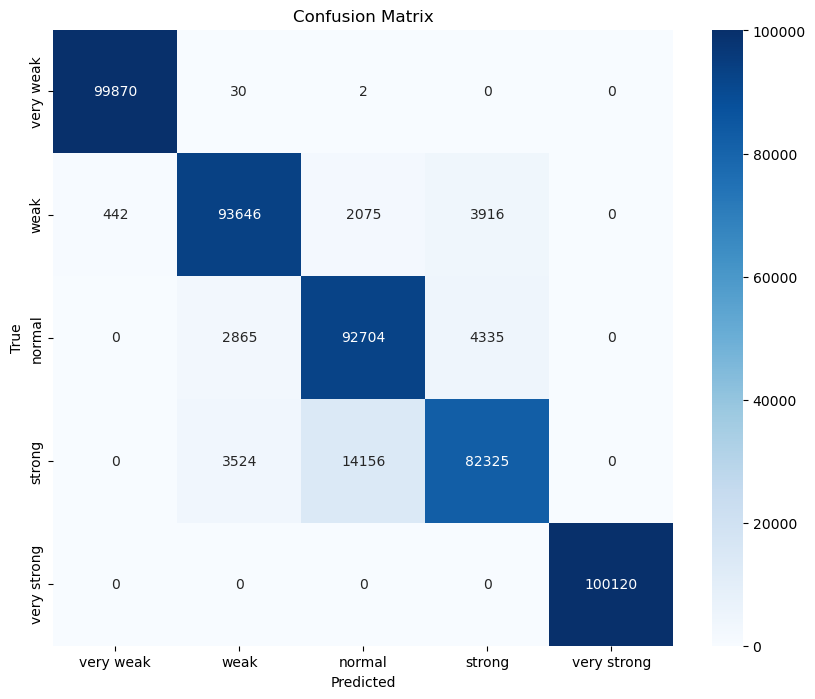


Classification Report:
              precision    recall  f1-score   support

   very weak       1.00      1.00      1.00     99902
        weak       0.94      0.94      0.94    100079
      normal       0.85      0.93      0.89     99904
      strong       0.91      0.82      0.86    100005
 very strong       1.00      1.00      1.00    100120

    accuracy                           0.94    500010
   macro avg       0.94      0.94      0.94    500010
weighted avg       0.94      0.94      0.94    500010



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# After training loop
model.eval()
all_preds = []
all_labels = []

# Gather all predictions and labels from the validation set
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
class_names = ['very weak','weak','normal','strong','very strong']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, and F1 Score
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:")
print(report)

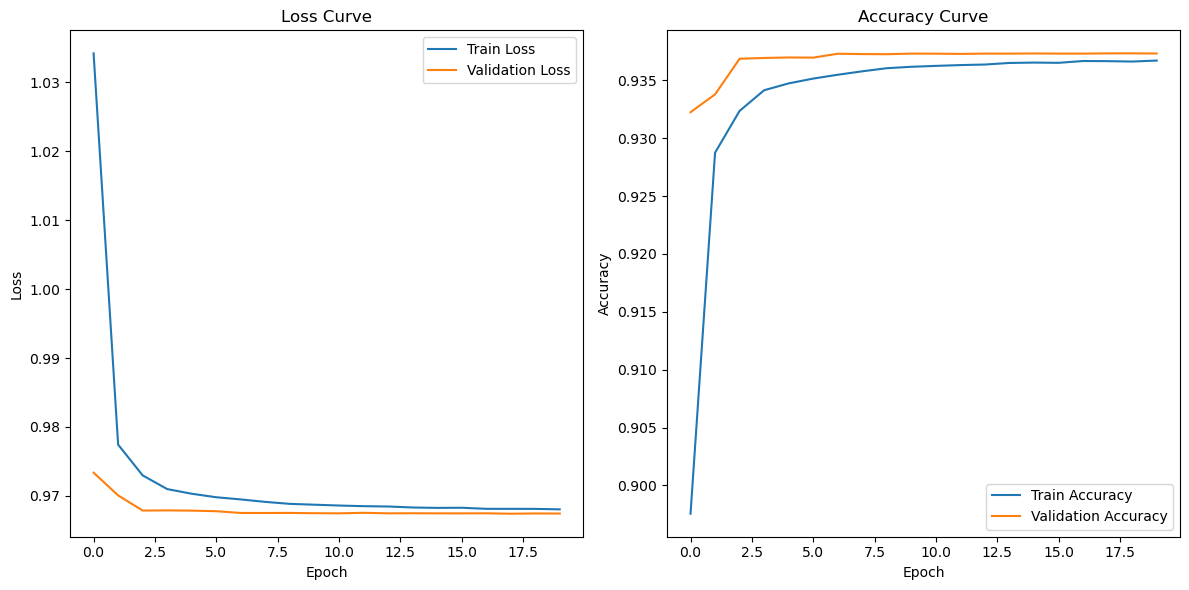

In [13]:
# Plot loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()


In [14]:
# Save the model's state_dict (parameters)
torch.save(model.state_dict(), "PasswordNN_v2.pth")
print("Model saved successfully.")


Model saved successfully.


In [15]:
# If you want to load the trained model directly - uncomment the following code

# model = PasswordNN(input_dim=X_train.shape[1], output_dim=3)
# model.load_state_dict(torch.load("PasswordNN.pth"))
# model.eval()
# print("Model loaded successfully.")
